In [2]:
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

# To store dataset in a Pandas Dataframe
import io
data = pd.read_excel(io.BytesIO(uploaded['AirQualityUCI.xlsx']))

Saving AirQualityUCI.xlsx to AirQualityUCI.xlsx


In [4]:
data.head()
#0 Date (DD/MM/YYYY)
#1 Time (HH.MM.SS)
#2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
#3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
#4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
#5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
#6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
#7 True hourly averaged NOx concentration in ppb (reference analyzer)
#8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
#9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
#10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
#11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
#12 Temperature in Â°C
#13 Relative Humidity (%)
#14 AH Absolute Humidity

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [5]:
    def printNullValues(data):
       total = data.isnull().sum().sort_values(ascending = False)
       total = total[data.isnull().sum().sort_values(ascending = False) != 0]
       percent = total / len(data) * 100
       percent = percent[data.isnull().sum().sort_values(ascending = False) != 0]
       concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
       print (concat)
       print ( "-------------")

In [6]:
printNullValues(data)

Empty DataFrame
Columns: [Total, Percent]
Index: []
-------------


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [8]:
data.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [9]:
# In the dataset missing values are tagged with -200 value.We replace them with nan
import numpy as np
data = data.replace(-200, np.nan)
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.707856,218.811816,10.082993,939.029205,246.881252,835.370973,113.075515,1456.143486,1022.780725,18.316054,49.232360,1.025530
std,1.453252,217.084571,204.459921,7.449640,266.829000,212.971224,256.815106,48.359250,346.204540,398.480897,8.832888,17.316389,0.403813
min,0.100000,647.250000,7.000000,0.149048,383.250000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.100000,936.750000,67.000000,4.436942,734.375000,98.000000,657.875000,78.000000,1226.625000,731.375000,11.787500,35.812500,0.736769
50%,1.800000,1063.000000,150.000000,8.239851,909.000000,179.800000,805.500000,109.000000,1462.750000,963.250000,17.750000,49.550000,0.995395
75%,2.900000,1231.250000,297.000000,13.988478,1116.250000,326.000000,969.250000,142.000000,1673.500000,1273.375000,24.400000,62.500001,1.313701
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In [10]:
#Get the current index of datafram data.
data.index

RangeIndex(start=0, stop=9357, step=1)

In [11]:
#Combine values in "Date" and "Time" as new column "Datetime"
#or "Datetime", convert string values to datetime data type
from datetime import datetime

data.loc[:,'Datetime'] = pd.to_datetime(data.Date.astype(str)+' '+data.Time.astype(str))
data.loc[:,'Datetime']

0      2004-03-10 18:00:00
1      2004-03-10 19:00:00
2      2004-03-10 20:00:00
3      2004-03-10 21:00:00
4      2004-03-10 22:00:00
               ...        
9352   2005-04-04 10:00:00
9353   2005-04-04 11:00:00
9354   2005-04-04 12:00:00
9355   2005-04-04 13:00:00
9356   2005-04-04 14:00:00
Name: Datetime, Length: 9357, dtype: datetime64[ns]

In [12]:
#Store the values of Datetime in a list
from datetime import datetime
DateTime = []
for x in data['Datetime']:
    DateTime.append((x))

In [13]:
DateTime

[Timestamp('2004-03-10 18:00:00'),
 Timestamp('2004-03-10 19:00:00'),
 Timestamp('2004-03-10 20:00:00'),
 Timestamp('2004-03-10 21:00:00'),
 Timestamp('2004-03-10 22:00:00'),
 Timestamp('2004-03-10 23:00:00'),
 Timestamp('2004-03-11 00:00:00'),
 Timestamp('2004-03-11 01:00:00'),
 Timestamp('2004-03-11 02:00:00'),
 Timestamp('2004-03-11 03:00:00'),
 Timestamp('2004-03-11 04:00:00'),
 Timestamp('2004-03-11 05:00:00'),
 Timestamp('2004-03-11 06:00:00'),
 Timestamp('2004-03-11 07:00:00'),
 Timestamp('2004-03-11 08:00:00'),
 Timestamp('2004-03-11 09:00:00'),
 Timestamp('2004-03-11 10:00:00'),
 Timestamp('2004-03-11 11:00:00'),
 Timestamp('2004-03-11 12:00:00'),
 Timestamp('2004-03-11 13:00:00'),
 Timestamp('2004-03-11 14:00:00'),
 Timestamp('2004-03-11 15:00:00'),
 Timestamp('2004-03-11 16:00:00'),
 Timestamp('2004-03-11 17:00:00'),
 Timestamp('2004-03-11 18:00:00'),
 Timestamp('2004-03-11 19:00:00'),
 Timestamp('2004-03-11 20:00:00'),
 Timestamp('2004-03-11 21:00:00'),
 Timestamp('2004-03-

In [14]:
#Convert DateTime list to series, and use it as the index of data
datetime = pd.Series(DateTime)
data.index = datetime
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
2004-03-10 18:00:00,2004-03-10,18:00:00,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,2004-03-10 18:00:00
2004-03-10 19:00:00,2004-03-10,19:00:00,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,2004-03-10 19:00:00
2004-03-10 20:00:00,2004-03-10,20:00:00,2.2,1402.00,88.0,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,2004-03-10 20:00:00
2004-03-10 21:00:00,2004-03-10,21:00:00,2.2,1375.50,80.0,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,2004-03-10 21:00:00
2004-03-10 22:00:00,2004-03-10,22:00:00,1.6,1272.25,51.0,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,2004-03-10 22:00:00


In [15]:
data.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
Datetime         datetime64[ns]
dtype: object

In [16]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.707856,218.811816,10.082993,939.029205,246.881252,835.370973,113.075515,1456.143486,1022.780725,18.316054,49.232360,1.025530
std,1.453252,217.084571,204.459921,7.449640,266.829000,212.971224,256.815106,48.359250,346.204540,398.480897,8.832888,17.316389,0.403813
min,0.100000,647.250000,7.000000,0.149048,383.250000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,1.100000,936.750000,67.000000,4.436942,734.375000,98.000000,657.875000,78.000000,1226.625000,731.375000,11.787500,35.812500,0.736769
50%,1.800000,1063.000000,150.000000,8.239851,909.000000,179.800000,805.500000,109.000000,1462.750000,963.250000,17.750000,49.550000,0.995395
75%,2.900000,1231.250000,297.000000,13.988478,1116.250000,326.000000,969.250000,142.000000,1673.500000,1273.375000,24.400000,62.500001,1.313701
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


Exploratory Analysis

Our target values are : 
1. PT08.S1(CO)
2. PT08.S2(NMHC)
3. PT08.S3(NOx)
4. PT08.S4(NO2)
5. PT08.S5(O3)


Identify target variables, S1-S5, and fill the missing values with the column mean



In [17]:
S1 = data['PT08.S1(CO)'].fillna(data['PT08.S1(CO)'].mean())
S2 = data['PT08.S2(NMHC)'].fillna(data['PT08.S1(CO)'].mean())
S3 = data['PT08.S3(NOx)'].fillna(data['PT08.S1(CO)'].mean())
S4 = data['PT08.S4(NO2)'].fillna(data['PT08.S1(CO)'].mean())
S5 = data['PT08.S5(O3)'].fillna(data['PT08.S1(CO)'].mean())

Text(0.5, 1.0, 'S5')

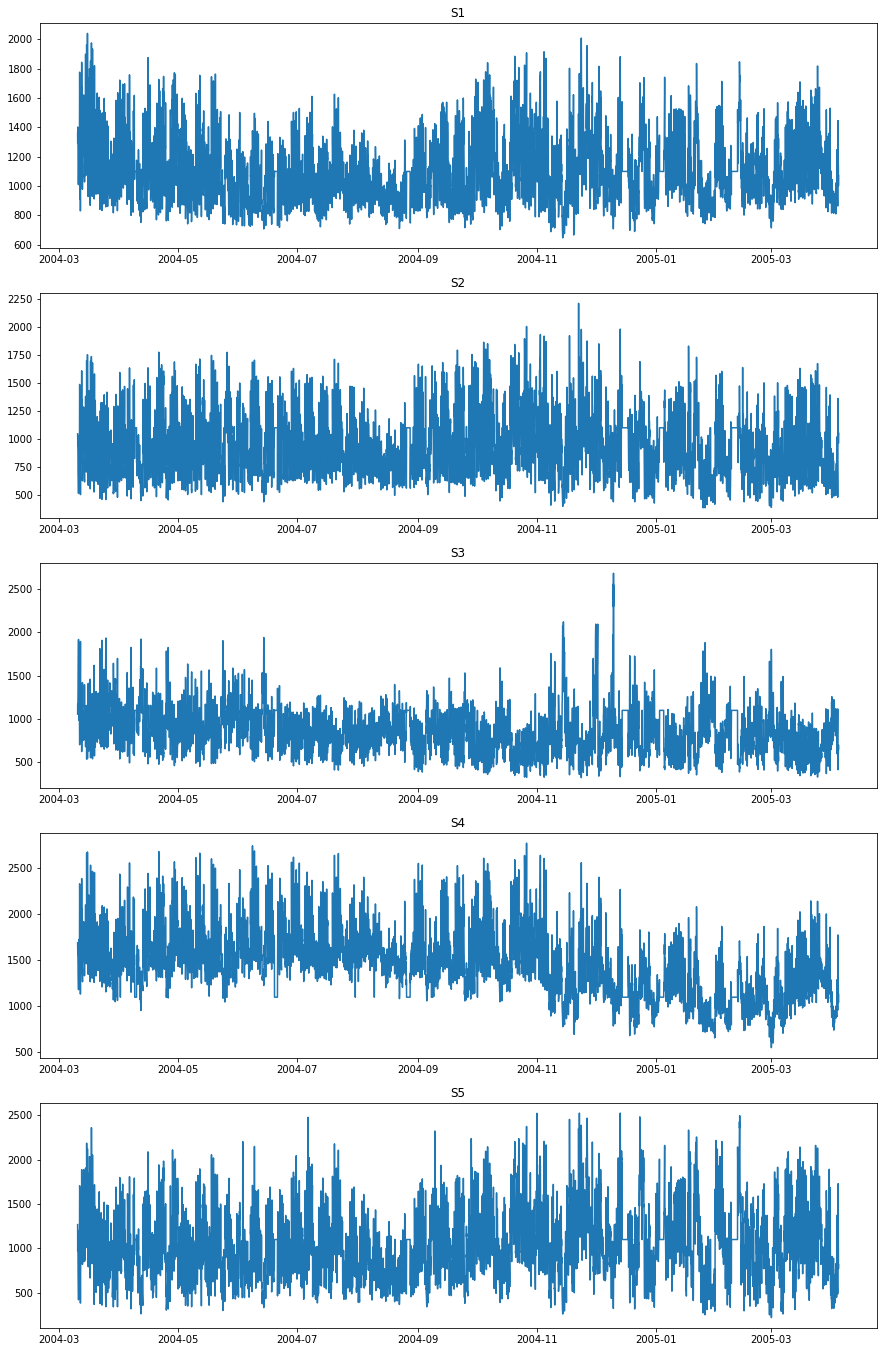

In [18]:
#Ploting the S1-S5
fig, axes = plt.subplots(5,1, figsize=(15,24))

axes[0].plot(S1)
axes[0].set_title ('S1')
axes[1].plot(S2)
axes[1].set_title ('S2')
axes[2].plot(S3)
axes[2].set_title ('S3')
axes[3].plot(S4)
axes[3].set_title ('S4')
axes[4].plot(S5)
axes[4].set_title ('S5')

Text(0.5, 1.0, 'S5')

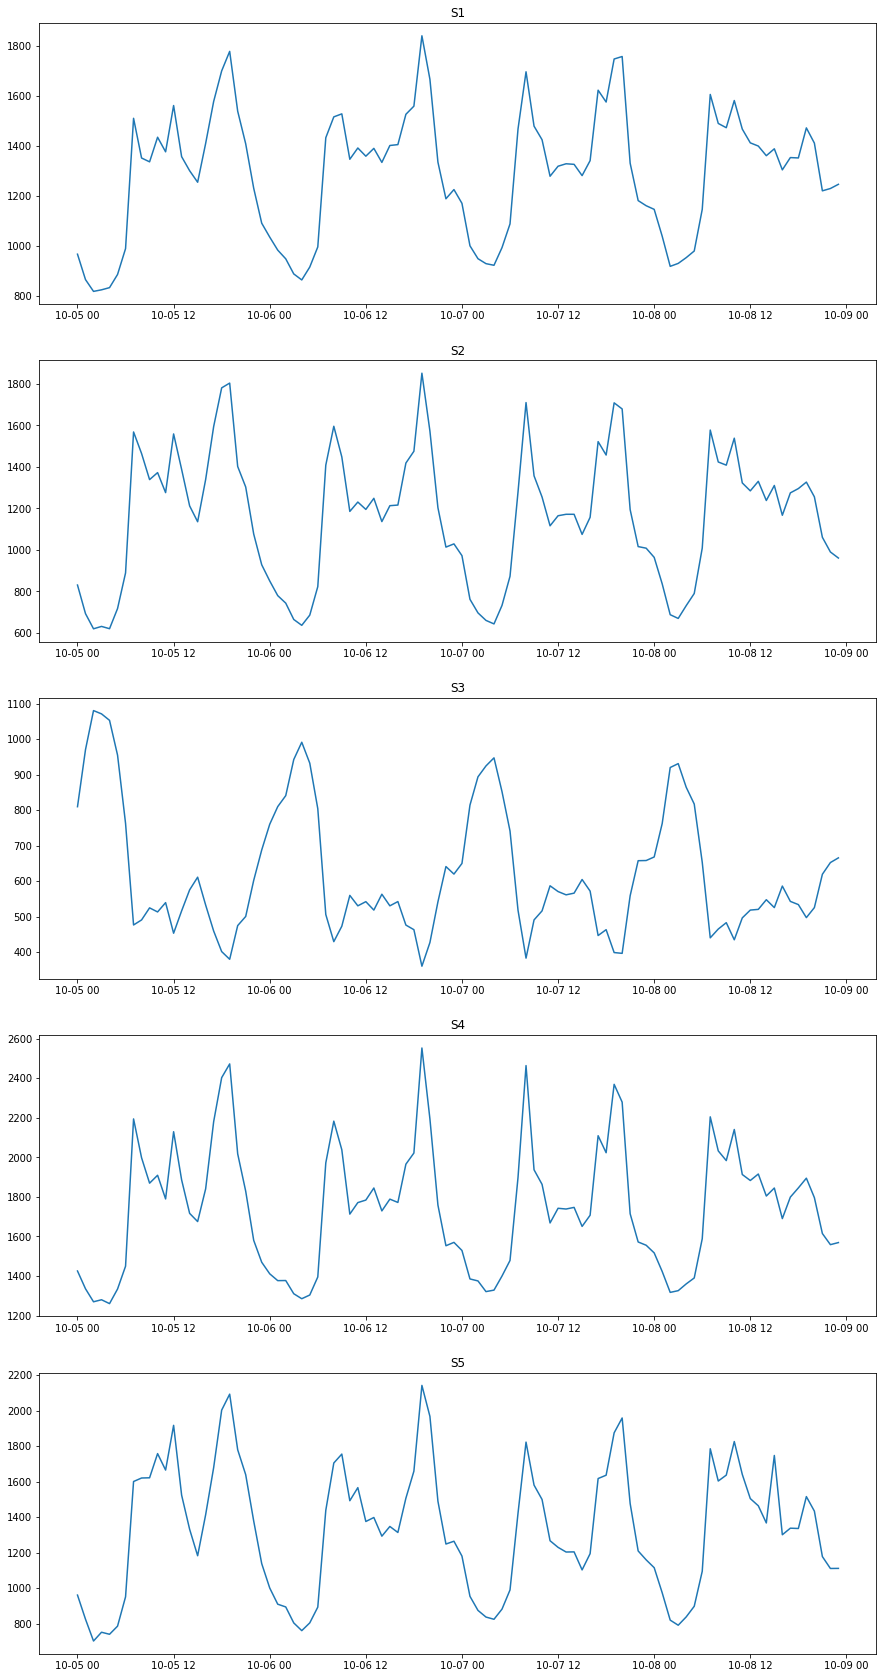

In [19]:
#Plots withn shorter period: '2004-10-05' - '2004-10-08', S1-S5
fig, axes = plt.subplots(5,1, figsize=(15,30))

axes[0].plot(S1['2004-10-05':'2004-10-08'])
axes[0].set_title ('S1')
axes[1].plot(S2['2004-10-05':'2004-10-08'])
axes[1].set_title ('S2')
axes[2].plot(S3['2004-10-05':'2004-10-08'])
axes[2].set_title ('S3')
axes[3].plot(S4['2004-10-05':'2004-10-08'])
axes[3].set_title ('S4')
axes[4].plot(S5['2004-10-05':'2004-10-08'])
axes[4].set_title ('S5')

Checking for Stationarity of Time Series.

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time and an autocovariance that does not depend on time

We’ll be using the rolling statistics plots along with Dickey-Fuller test results a lot so I have defined a function which takes a TS as input and generated them for us

In [20]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

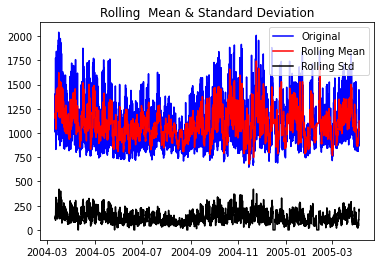

Results of Dickey-Fuller Test:
Test Statistic                -9.732748e+00
p-value                        8.914162e-17
#Lags Used                     3.800000e+01
Number of Observations Used    9.318000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [21]:
test_stationarity(S1)

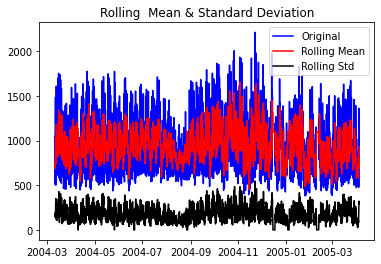

Results of Dickey-Fuller Test:
Test Statistic                -1.058984e+01
p-value                        6.571022e-19
#Lags Used                     3.700000e+01
Number of Observations Used    9.319000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [22]:
test_stationarity(S2)

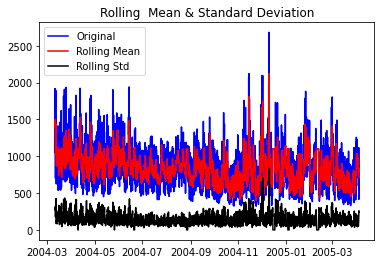

Results of Dickey-Fuller Test:
Test Statistic                -1.063146e+01
p-value                        5.201413e-19
#Lags Used                     3.600000e+01
Number of Observations Used    9.320000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [23]:
test_stationarity(S3)

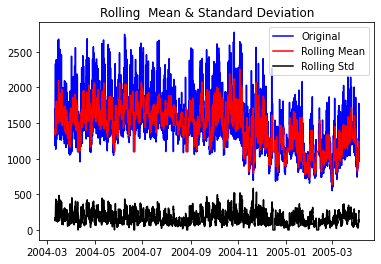

Results of Dickey-Fuller Test:
Test Statistic                -6.305128e+00
p-value                        3.337989e-08
#Lags Used                     3.700000e+01
Number of Observations Used    9.319000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [24]:
test_stationarity(S4)

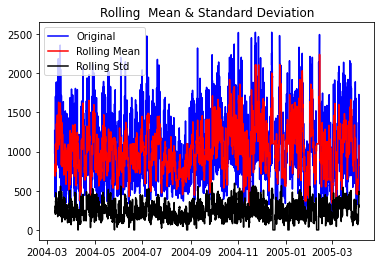

Results of Dickey-Fuller Test:
Test Statistic                -1.110065e+01
p-value                        3.873019e-20
#Lags Used                     3.600000e+01
Number of Observations Used    9.320000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [25]:
test_stationarity(S5)

We will try to make series stationary

We can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity.

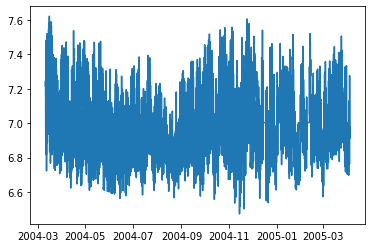

In [26]:
#let's take a log transform for simplicity:
S1_log = np.log(S1)
plt.plot(S1_log)

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

Aggregation – taking average for a time period like monthly/weekly averages
Smoothing – taking rolling averages
Polynomial Fitting – fit a regression model

We will apply smoothing here.




**Moving Average**

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics

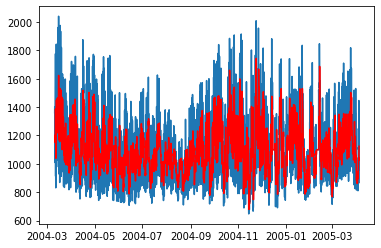

In [27]:
#Moving average
import matplotlib.pyplot as plt

moving_avg = S1.rolling(12).mean()
plt.plot(S1)
plt.plot(moving_avg, color = 'red')

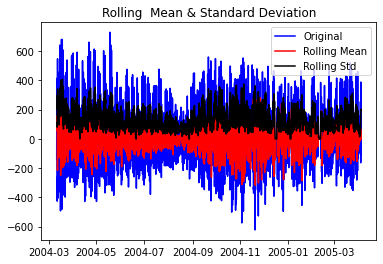

Results of Dickey-Fuller Test:
Test Statistic                  -19.581154
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    9309.000000
Critical Value (1%)              -3.431053
Critical Value (5%)              -2.861851
Critical Value (10%)             -2.566935
dtype: float64


In [28]:
S1_moving_avg_diff = S1 - moving_avg
S1_moving_avg_diff.dropna(inplace = True)
test_stationarity(S1_moving_avg_diff)

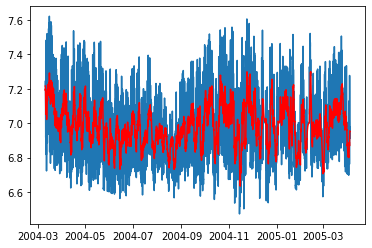

In [29]:
exp_weighted_avg = S1_log.ewm(halflife = 12).mean()
plt.plot(S1_log)
plt.plot(exp_weighted_avg, color = 'red')

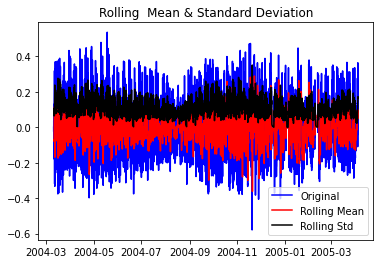

Results of Dickey-Fuller Test:
Test Statistic                -1.634710e+01
p-value                        2.957112e-29
#Lags Used                     3.600000e+01
Number of Observations Used    9.320000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [30]:
S1_log_ema_diff = S1_log - exp_weighted_avg
test_stationarity(S1_log_ema_diff)

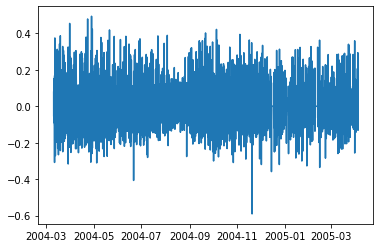

In [31]:
S1_log_diff = S1_log - S1_log.shift()
plt.plot(S1_log_diff)

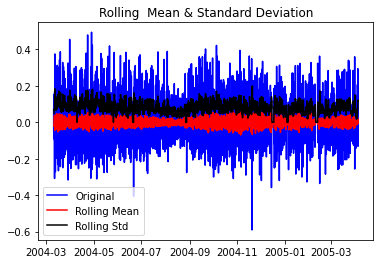

Results of Dickey-Fuller Test:
Test Statistic                -1.873303e+01
p-value                        2.030477e-30
#Lags Used                     3.700000e+01
Number of Observations Used    9.318000e+03
Critical Value (1%)           -3.431052e+00
Critical Value (5%)           -2.861850e+00
Critical Value (10%)          -2.566935e+00
dtype: float64


In [32]:
S1_log_diff.dropna(inplace = True)
test_stationarity(S1_log_diff)

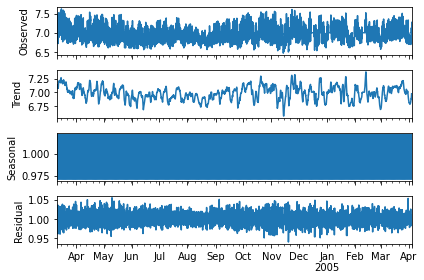

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(S1_log, model = "multiplicative") 
fig = result.plot()

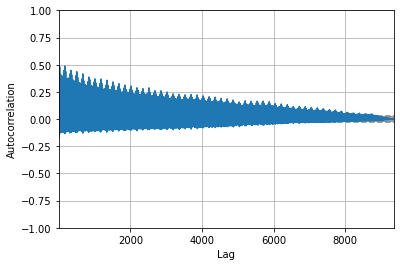

In [34]:
#ACF plot
pd.plotting.autocorrelation_plot(S1_log_diff)

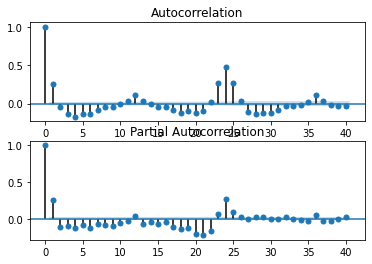

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(211)
plot_acf(S1_log_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(S1_log_diff, ax=plt.gca())
plt.show()

In [36]:
#Another method
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(S1_log_diff, nlags=20)
lag_pacf = pacf(S1_log_diff, nlags=20, method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


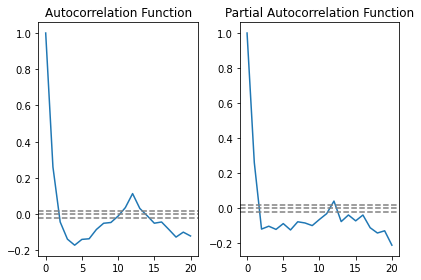

In [37]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(S1_log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(S1_log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(S1_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(S1_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

In [38]:
from statsmodels.tsa.arima_model import ARIMA, ARMAResults


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 65.5525')

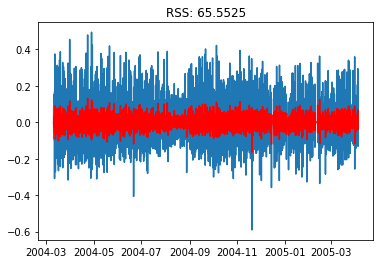

In [39]:
#AR Model
model = ARIMA(S1_log, order = (2,1,0))
results_AR = model.fit(disp = -1)
plt.plot(S1_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - S1_log_diff)**2)) #Residual sum of squares

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 65.9181')

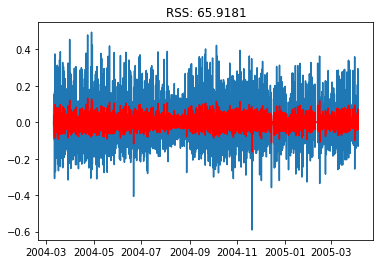

In [40]:
#MA Model
model = ARIMA(S1_log, order= (0, 1, 2))  
results_MA = model.fit(disp = -1)  
plt.plot(S1_log_diff)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - S1_log_diff)**2))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 58.9219')

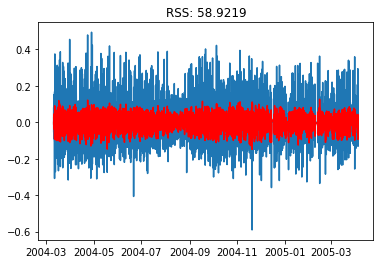

In [41]:
#Combined Model 
model = ARIMA(S1_log, order = (2, 1, 2))  
results_ARIMA = model.fit(disp = -1)  
plt.plot(S1_log_diff)
plt.plot(results_ARIMA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - S1_log_diff)**2))

In [43]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

2004-03-10 19:00:00   -0.000021
2004-03-10 20:00:00   -0.013328
2004-03-10 21:00:00    0.029415
2004-03-10 22:00:00   -0.004735
2004-03-10 23:00:00   -0.020686
dtype: float64

In [44]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

2004-03-10 19:00:00   -0.000021
2004-03-10 20:00:00   -0.013349
2004-03-10 21:00:00    0.016066
2004-03-10 22:00:00    0.011331
2004-03-10 23:00:00   -0.009355
dtype: float64

In [45]:
predictions_ARIMA_log = pd.Series(S1_log.iloc[0], index=S1_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

2004-03-10 18:00:00    7.215240
2004-03-10 19:00:00    7.215219
2004-03-10 20:00:00    7.201891
2004-03-10 21:00:00    7.231306
2004-03-10 22:00:00    7.226571
dtype: float64

Text(0.5, 1.0, 'RMSE: 1359.5956')

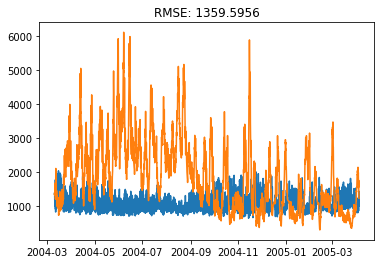

In [46]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(S1)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-S1)**2)/len(S1)))

Another Method(using SARIMAX)

In [47]:
import itertools
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))      #Generate all different combinations of p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]       #Generate all different combinations of seasonal p, q and q triplet

In [48]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")           #Specify to ignore warning messages
AIC_df = pd.DataFrame({}, columns = ['param', 'param_seasonal', 'AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(S1_log, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            #print('ARIMA{}x{}-AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[param, param_seasonal, results.aic]], columns = ['param', 'param_seasonal', 'AIC'])
            AIC_df = AIC_df.append(temp, ignore_index = True)
            del temp
        except:
            continue

In [49]:
min_aic = AIC_df.sort_values(by = 'AIC').iloc[0]    #Row with minimum AIC value
model = sm.tsa.statespace.SARIMAX(S1_log, order = min_aic.param, seasonal_order = min_aic.param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()
#print(results.summary())
print(results.summary().tables[1])






                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8702      0.006    152.905      0.000       0.859       0.881
ma.L1          0.2064      0.010     21.554      0.000       0.188       0.225
ar.S.L12      -0.1714      0.010    -17.111      0.000      -0.191      -0.152
ma.S.L12      -0.9370      0.003   -275.473      0.000      -0.944      -0.930
sigma2         0.0051   5.75e-05     89.050      0.000       0.005       0.005


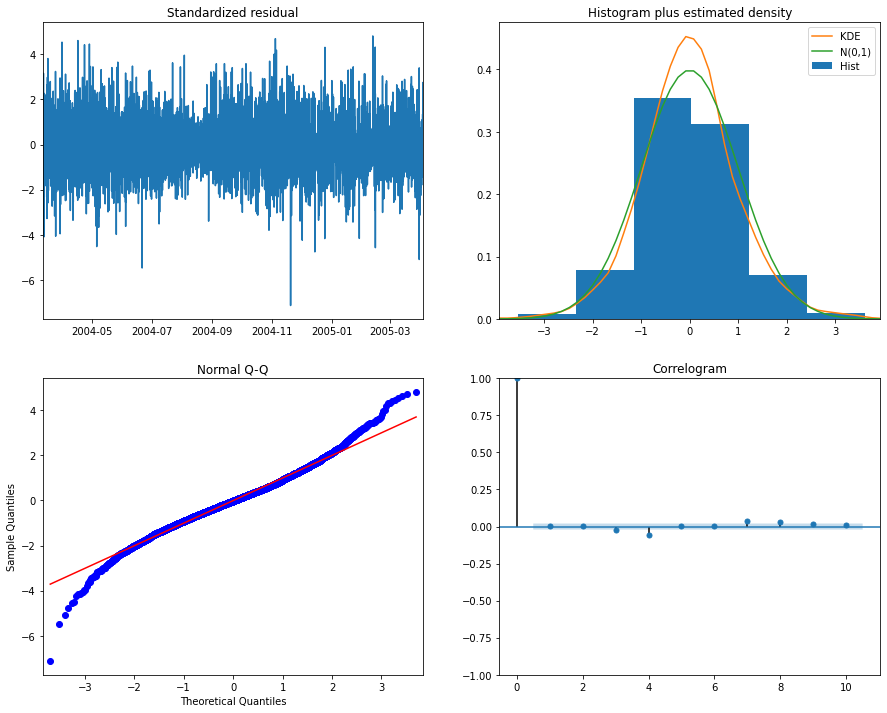

In [50]:
#The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower to 0.05, so it is reasonable to retain all of them in our model.

results.plot_diagnostics(figsize=(15, 12))    #Generate model diagnostics and investigate for any unusual behavior.
plt.show()

In [51]:
#Obtain values for forecasts of the time series from 2005
pred = results.get_prediction(start = pd.to_datetime('2005-03-10'), dynamic = False)
#Obtain associated confidence intervals for forecasts of the time series
pred_ci = pred.conf_int()
pred_ci.head()




,lower PT08.S1(CO),upper PT08.S1(CO)
2004-05-10 00:00:00,6.826374,7.106847
2004-05-10 01:00:00,6.737370,7.017843
2004-05-10 02:00:00,6.569613,6.850086
2004-05-10 03:00:00,6.589672,6.870145
2004-05-10 04:00:00,6.565104,6.845577


2005-04-04 15:00:00    6.987507
2005-04-04 16:00:00    6.982109
2005-04-04 17:00:00    7.001466
2005-04-04 18:00:00    7.044461
2005-04-04 19:00:00    7.132966
2005-04-04 20:00:00    7.169056
2005-04-04 21:00:00    7.143069
2005-04-04 22:00:00    7.097111
2005-04-04 23:00:00    7.075281
2005-04-05 00:00:00    7.060241
2005-04-05 01:00:00    7.025144
2005-04-05 02:00:00    6.999019
2005-04-05 03:00:00    6.986789
2005-04-05 04:00:00    6.985335
2005-04-05 05:00:00    7.003974
2005-04-05 06:00:00    7.046936
2005-04-05 07:00:00    7.135130
2005-04-05 08:00:00    7.171104
2005-04-05 09:00:00    7.145202
2005-04-05 10:00:00    7.099396
2005-04-05 11:00:00    7.077639
2005-04-05 12:00:00    7.062648
2005-04-05 13:00:00    7.027667
2005-04-05 14:00:00    7.001629
2005-04-05 15:00:00    6.989440
2005-04-05 16:00:00    6.987990
2005-04-05 17:00:00    7.006568
2005-04-05 18:00:00    7.049387
2005-04-05 19:00:00    7.137291
2005-04-05 20:00:00    7.173145
Freq: H, dtype: float64


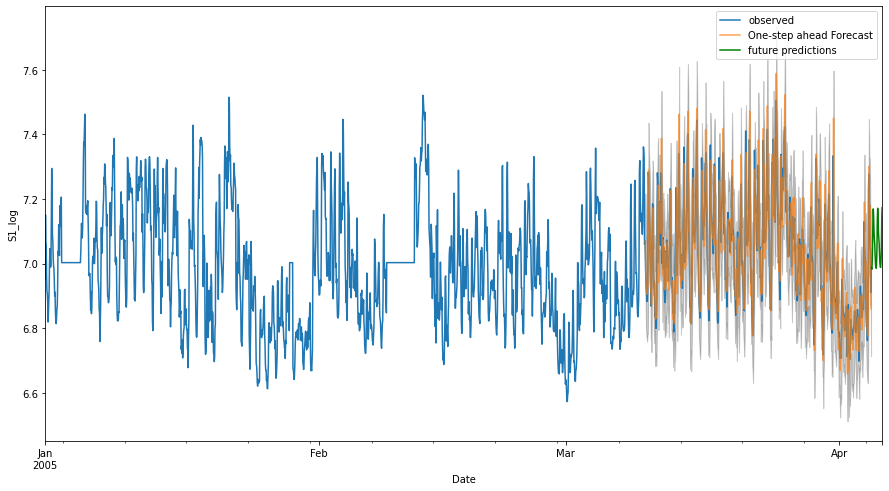

In [77]:

ax = S1_log['2005':].plot(figsize=[15, 8], label='observed')
pred.predicted_mean.plot(figsize=[15, 8], ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('S1_log')
plt.legend()

forecast = results.forecast(30)
print(forecast)
forecast.plot(figsize=[15, 8], color='green', label='future predictions')
plt.legend()
plt.show()

In [74]:
pred.predicted_mean.head()

2005-03-10 00:00:00    7.069974
2005-03-10 01:00:00    7.014645
2005-03-10 02:00:00    6.947328
2005-03-10 03:00:00    6.925169
2005-03-10 04:00:00    6.914948
Freq: H, dtype: float64

In [76]:
S1_log_forecasted = pred.predicted_mean     
S1_log_original = S1_log['2004-05-10':]
mse = ((S1_log_forecasted - S1_log_original) ** 2).mean()  #Mean square error
print('Mean Squared Error of forecast : {}'.format(round(mse,3)))
mae = mean_absolute_percentage_error(S1_log_original,S1_log_forecasted  )
print("Mean Absolute Percentage Error: {0:.2f}%".format(error))
# Compute the mean square error
rmse = (((S1_forecasted - S1_log_original) ** 2).mean()) ** 0.5
print('The Root Mean Squared Error of our prediction is {}'.format(round(rmse, 2)))



Mean Squared Error of forecast : 0.005
Mean Absolute Percentage Error: 0.76%
The Root Mean Squared Error of our prediction is 0.07
